In [84]:
# -------------------------------
# Libraries
# -------------------------------
%matplotlib inline
import os.path
from math import *
import numpy as np
from tramway.helper import *
from tramway.helper.simulation import *
from tramway.helper.tessellation import *
from tramway.helper.inference import *
from tramway.plot.mesh import plot_delaunay
#from scipy.stats import skellam
#from scipy.optimize import fmin,minimize

#--------------------------------
# Functions
#--------------------------------
def D_field(r,t):
    '''Function defining the diffusivity field.'''
    return D - (D-D0)*np.exp(-np.sum((r/r_scale-mu_r)**2)/sig_r) 

def new_tracers(t):
    '''Function drawing the number of tracers to appear each time-step from a Poisson distribution.'''
    return np.random.poisson(mu_on)

#--------------------------------
# Constants and parameters:
#--------------------------------
# Tesselation method and name:
tessellation_method = 'hexagon'
mesh_label = '{}'.format(tessellation_method) #, location_count, min_location_count)
min_loc_count = 0
# Optimization parameters:
nt_method = ('nT_test02_hex', 'NM')
tol = 1e-2

# Normalized placement and with of diffusivity well:
mu_r=np.array([0.5,0.5]) 
sig_r=0.05
# Size of the bounding box:
r_scale = 10. # [um]
# Reference distance to set mesh size:
ref_distance = 1. # [mu]

# baseline diffusivity:
D = 0.5 # [um^2.s^-1]
# diffusivity at the bottom of the sink:
D0 = 0.05 # [um^2.s^-1]
# number of trajectories:
M = 100
# time step:
dt = 0.05 # [s]
# average trajectory lifetime (+ p_off and mu_on):
tau = 0.25
p_off = dt/tau
mu_on = p_off*M
# Simulation duration:
T = 0.25 # [s]
# position noise:
sigma = 0. # [um]



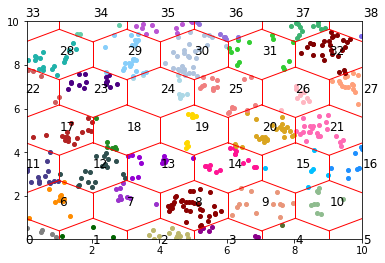

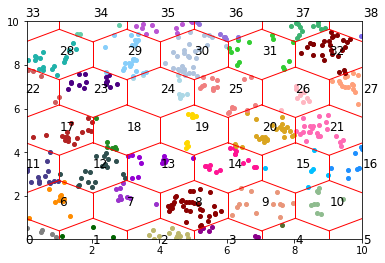

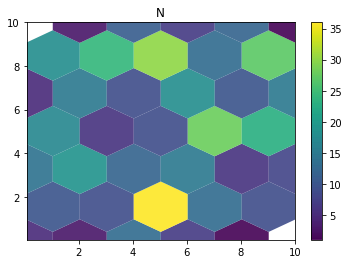

In [85]:
#--------------------------------
# Simulate:
#--------------------------------
## generate the trajectories
nxyt = random_walk(diffusivity=D_field, duration=T, lifetime_tau=tau, single=True, reflect=True, 
                  trajectory_mean_count=M, box=[0.,0.,r_scale,r_scale], )
nxyt = nxyt.dropna()
xyt = nxyt.drop('n',axis=1)

# tesselate for trajectories:
cells_nxyt = tessellate(nxyt, tessellation_method, ref_distance=ref_distance, min_location_count=0,
           strict_min_location_count=min_loc_count,
           force=True, output_label=mesh_label)
# tesselate for positions:
cells_xyt = tessellate(xyt, tessellation_method, ref_distance=ref_distance, min_location_count=0,
           strict_min_location_count=min_loc_count,
           force=True, output_label=mesh_label)


## plot for trajectories and for positions:
cell_plot(cells_nxyt, cell_indices=True)
cell_plot(cells_xyt, cell_indices=True)
map_plot((pd.DataFrame(cells_xyt.location_count, columns=['N'])),cells=cells_xyt) #,cmap='inferno') 

In [81]:
# ------------------------------------------------
# infer in D mode without spatial regularization
# ------------------------------------------------
maps_nxyt = infer(cells_nxyt, 'D', 
             sigma=sigma, verbose=True)

print(maps_nxyt)

d mode: elapsed time: 41ms
mode:      d
runtime:   0.041349172592163086
sigma:     0.0
variables: ['diffusivity']
maps:      <class 'pandas.core.frame.DataFrame'>


In [ ]:
# ------------------------------------------------
# infer using nontracking (D mode without spatial regularization only)
# ------------------------------------------------
maps_xyt = infer(cells_xyt, nt_method[0], new_cell=Locations, dt=dt, p_off=p_off, mu_on=mu_on,
        method=nt_method[1], tol=tol)



S: 0 3.4641016151377544
1 3.4641016151377544
6 6.928203230275509
; total: 10.392304845413264 mu^2
Cell no.: 0 ; sum(N): 5 , possible links: 3 , avg(N): 1.0
Outer cells: sum(N): 13 , possible links: 7 , avg(N): 2.6
All cells: sum(N): 18 , possible links: 11 , avg(N): 3.6
[0, 2, 1, 1, 1]
[3, 4, 2, 4, 5]
 final_simplex: (array([[0.52361328, 0.26521484],
       [0.51365723, 0.26394043],
       [0.51382812, 0.26898437]]), array([48.59915354, 48.59926068, 48.59975187]))
           fun: 48.59915354492355
       message: 'Optimization terminated successfully.'
          nfev: 32
           nit: 16
        status: 0
       success: True
             x: array([0.52361328, 0.26521484])
D corrected for motion blur and localization error: 0.7104199218749983
1.2695996761322021 s

S: 1 3.4641016151377544
0 3.4641016151377544
2 6.928203230275509
6 10.392304845413264
7 13.856406460551018
; total: 17.32050807568877 mu^2
Cell no.: 1 ; sum(N): 3 , possible links: 1 , avg(N): 0.6
Outer cells: sum(N): 37 ,

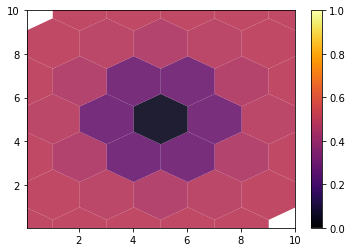

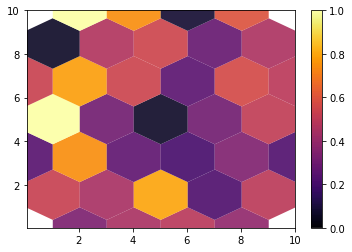

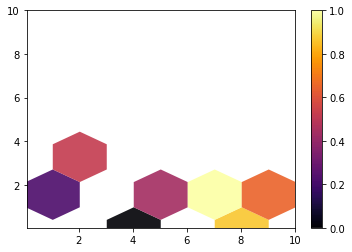

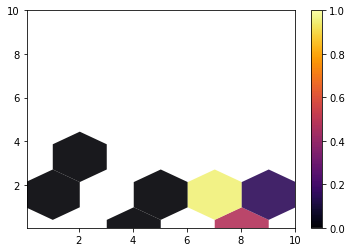

In [102]:
centers = cells_nxyt.tessellation.cell_centers
D_true = pd.DataFrame([D_field(c_,0.) for c_ in centers],columns=['D'])
maps_true = Maps(D_true)
map_plot(maps_true, cells=cells_nxyt, title=False, cmap='inferno', clim=[0,1])

## plot the force
map_plot(maps_nxyt, cells=cells_nxyt, title=False, variable='diffusivity',cmap='inferno',clim=[0,1])
# other variables are 'diffusivity' and 'potential'

map_plot(maps_xyt, cells=cells_xyt, title=False, cmap='inferno',clim=[0,1])

maps_diffs = Maps(pd.DataFrame(maps_xyt.maps['D'] - maps_nxyt.maps['diffusivity'],columns=['D']))
map_plot(maps_diffs, cells=cells_xyt, title=False, cmap='inferno',clim=[0,1])


In [44]:
analysis_tree_nxyt = Analyses(nxyt)
analysis_tree_nxyt.add(cells_nxyt, label='mesh')
analysis_tree_nxyt['mesh'].add(maps_nxyt, label='diffusivity')
print(analysis_tree_nxyt['mesh']['diffusivity'].data.maps)
save_rwa(f'analyses_nxyt,D=[{D0},{D}],tau={tau},dt={dt},sig_r={sig_r},box={r_scale},T={T},M={M},r_cell={ref_distance}.rwa', analysis_tree_nxyt)

#maps_xyt = pd.read_csv('Estimates-1.txt', sep='\t', index_col=0, names=['diffusivity'])
analysis_tree_xyt = Analyses(xyt)
analysis_tree_xyt.add(cells_xyt, label='mesh')
analysis_tree_xyt['mesh'].add(maps_xyt, label='diffusivity')
print(analysis_tree_xyt['mesh']['diffusivity'].data.maps)
save_rwa(f'analyses_xyt,D=[{D0},{D}],tau={tau},dt={dt},sig_r={sig_r},box={r_scale},T={T},M={M},r_cell={ref_distance}.rwa', analysis_tree_xyt)


    diffusivity
2      0.017706
4      0.628788
5      0.174295
8      0.343934
9      0.831728
10     0.485919
12     0.398245
overwrite file 'analyses_nxyt,D=[0.05,0.5],tau=0.25,dt=0.05,T=0.25,M=10.rwa': [N/y] y
           D
2   0.000000
4   0.869417
5   0.186297
6   0.225000
8   0.441207
9   1.179513
10  0.651486
12  0.520840


In [50]:
D_field(np.array([5.,5.]),0.)

0.04999999999999999

In [96]:
print(cells_nxyt.tessellation.cell_centers)

[[ 0.03468241 -0.18095883]
 [ 2.03468241 -0.18095883]
 [ 4.03468241 -0.18095883]
 [ 6.03468241 -0.18095883]
 [ 8.03468241 -0.18095883]
 [10.03468241 -0.18095883]
 [ 1.03468241  1.55109198]
 [ 3.03468241  1.55109198]
 [ 5.03468241  1.55109198]
 [ 7.03468241  1.55109198]
 [ 9.03468241  1.55109198]
 [ 0.03468241  3.28314279]
 [ 2.03468241  3.28314279]
 [ 4.03468241  3.28314279]
 [ 6.03468241  3.28314279]
 [ 8.03468241  3.28314279]
 [10.03468241  3.28314279]
 [ 1.03468241  5.01519359]
 [ 3.03468241  5.01519359]
 [ 5.03468241  5.01519359]
 [ 7.03468241  5.01519359]
 [ 9.03468241  5.01519359]
 [ 0.03468241  6.7472444 ]
 [ 2.03468241  6.7472444 ]
 [ 4.03468241  6.7472444 ]
 [ 6.03468241  6.7472444 ]
 [ 8.03468241  6.7472444 ]
 [10.03468241  6.7472444 ]
 [ 1.03468241  8.47929521]
 [ 3.03468241  8.47929521]
 [ 5.03468241  8.47929521]
 [ 7.03468241  8.47929521]
 [ 9.03468241  8.47929521]
 [ 0.03468241 10.21134602]
 [ 2.03468241 10.21134602]
 [ 4.03468241 10.21134602]
 [ 6.03468241 10.21134602]
 

In [73]:
points = analysis_tree_nxyt['mesh'].data.points
indices = analysis_tree_nxyt['mesh'].data.cell_index

       n         x         y     t
1    1.0  5.904527  4.649401  0.10
2    2.0  3.806269  6.806939  0.05
3    2.0  3.840845  6.668946  0.10
4    2.0  3.612405  6.729960  0.15
5    3.0  2.539564  7.468139  0.05
6    3.0  2.835517  7.373315  0.10
7    3.0  2.605248  7.432950  0.15
8    3.0  2.428678  7.102879  0.20
9    3.0  2.172974  7.050712  0.25
10   4.0  4.811175  3.613488  0.05
11   4.0  4.992175  3.519342  0.10
12   4.0  4.994361  3.675268  0.15
13   4.0  4.783194  3.664095  0.20
14   4.0  4.891902  3.724443  0.25
15   5.0  1.519452  2.566573  0.05
16   5.0  1.454730  2.564031  0.10
17   5.0  1.476061  2.428598  0.15
18   6.0  7.140243  6.321224  0.05
19   6.0  7.527781  6.303079  0.10
20   6.0  7.284990  6.863352  0.15
21   6.0  7.759584  7.180887  0.20
22   7.0  4.245765  6.304823  0.05
23   7.0  4.135217  6.425692  0.10
24   8.0  5.241920  6.041381  0.05
25   8.0  5.531235  6.137871  0.10
26   8.0  5.346488  6.019392  0.15
27   8.0  5.416777  6.069561  0.20
28   9.0  3.085701  

In [74]:
analysis_tree = load_rwa('my_analyses.rwa')


tessellation:               <class 'tramway.tessellation.hexagon.HexagonalMesh'>
points:                     <class 'pandas.core.frame.DataFrame'>
cell_index:                 <class 'numpy.ndarray'>
location_count:             None
number_of_cells:            14
bounding_box:               None
@method:                    hexagon
@tessellation:              min_probability:    None
                            avg_probability:    None
                            max_probability:    None
                            min_distance:       1.6
                            avg_distance:       4.0
                            avg_location_count: 0
@partition:                 min_location_count: 0
@strict_min_location_count: 0


In [99]:
D_true

,D
0,0.499985
1,0.499639
2,0.498259
3,0.498307
4,0.499667
5,0.499987
6,0.498204
7,0.480745
8,0.458320
9,0.481785
